##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets | Features

This notebook contains code focused on analysing features for the final model.

**Full Name:** `Xavier Travers`

**Student ID:** `1178369`

First, read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# feature extractors
from features import *

# import the data
train_data = pd.read_csv("../datasets/Train.csv", sep=',')
test_data = pd.read_csv("../datasets/Test.csv", sep=',')

# Create the output dataframe
train_output = train_data.copy()
train_output['clean-text'] = train_output['text'].apply(lambda t: clean_tweet(t))
train_tweets = train_output[['text']].values[:, 0]
# train_clean_tweets = train_output[['clean-text']].values[:, 0]
test_output = test_data.copy()

# add the word lists
train_output['words'] = generate_word_lists(
    train_output[['text']].values[:, 0])
test_output['words'] = generate_word_lists(test_output[['text']].values[:, 0])

# extract the sentiments just for comparisons
train_sentiments = train_output[['sentiment']].values[:, 0]

# Top best number
MAX_FEATURES = 2000
# STOP_WORDS = list(stopwords.words('english'))
STOP_WORDS = None

# print the head of both lists just to check that it worked
print(train_output.head())
print(test_output.head())

print(train_tweets)

# Count the occurrences of each class
sentiment_counts = Counter(train_sentiments)
print(sentiment_counts)


   Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   

                                                text sentiment  \
0   doctors hit campaign trail as race to medical...   neutral   
1   is anybody going to the radio station tomorro...  positive   
2   i just found out naruto didn't become the 5th...   neutral   
3   "prince george reservist who died saturday ju...   neutral   
4   season in the sun versi nirvana rancak gak..s...  positive   

                                          clean-text  \
0  doctors hit campaign trail as race to medical ...   
1  is anybody going to the radio station tomorrow...   
2  i just found out naruto didn t become the th h...   
3  prince george reservist who died saturday just...   
4  season in the sun versi nirvana rancak gak slo...   

                                           

### Generating Plots for comparison

Different plots will be used to compare how features differ over the sentiments extracted from the tweets.


In [2]:
# Create histograms to compare the distributions across the sentiments
def compare_histograms(numeric_data, sentiments,
                       label="", use_bins=True, separate=False):
    COLOURS = ["blue", "red", "green", "purple"]
    index = 0

    # set the bins of the histograms
    bins = None
    if use_bins:
        bins = range(min(numeric_data), 1 + max(numeric_data))

    if not separate:
        f, axes = plt.subplots(1, 4)
        f.set_size_inches([15, 5])

        # set the labels
        f.supxlabel(label)
        f.supylabel("Relative Frequency")
        f.suptitle(f'Comparing "{label}" across the different sentiments')

        # display the plots
        axes[index].hist(numeric_data,
                         density=True, color=COLOURS[index], bins=bins)
        if use_bins:
            axes[index].set_ylim([0, 1.2])
        axes[index].set_title("All Sentiments")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_numeric_data = numeric_data[sentiments == s]
            axes[index].hist(sub_numeric_data,
                             density=True, color=COLOURS[index], bins=bins)
            if use_bins:
                axes[index].set_ylim([0, 1.2])
            axes[index].set_title(f'{s.upper()} Sentiment')
    else:
        plt.figure(figsize=(15, 5))
        plt.hist(numeric_data,
                 density=True, color=COLOURS[index], bins=bins)
        plt.title("All Sentiments")
        plt.xlabel(label)
        plt.ylabel("Relative Frequency")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_numeric_data = numeric_data[sentiments == s]
            plt.figure(figsize=(15, 5))
            plt.hist(sub_numeric_data,
                     density=True, color=COLOURS[index], bins=bins)
            plt.title(f'{s.upper()} Sentiment')
            plt.xlabel(label)
            plt.ylabel("Relative Frequency")

# Create bar graph to compare the distributions of discrete features across the sentiments


def compare_bar_graphs(dict_data, sentiments, label="", separate=False,
                       rating_type='relative', max_features=None):
    COLOURS = ["blue", "red", "green", "purple"]
    index = 0

    # sum the count dictionary (occurrences of the keys)
    def generate_dict_sum(condition=[True]):
        dict_sums = dict()
        for (key, arr) in dict_data.items():
            if rating_type == 'sum':
                dict_sums[key] = np.sum(arr[tuple(condition)])
            elif rating_type == 'relative':
                dict_sums[key] = np.sum(arr[tuple(condition)]) / np.sum(arr)
            else:
                dict_sums[key] = np.ma.average(arr[tuple(condition)])
        return dict_sums
    dict_sums = generate_dict_sum()

    # sort the names and values of the dict sums in decreasing order
    def sorted_values_names(dict_sums):
        values = list(dict_sums.values())
        names = list(dict_sums.keys())
        zipped = sorted(zip(values, names), reverse=True)
        values = [z[0] for z in zipped]
        names = [z[1] for z in zipped]
        if max_features is not None:
            return (values[:max_features], names[:max_features])
        else:
            return (values, names)

    values, names = sorted_values_names(dict_sums)

    # display the plots
    if not separate:
        f, axes = plt.subplots(1, 4)
        f.set_size_inches([15, 5])

        # set the labels
        f.supxlabel(label)
        f.supylabel(f"{rating_type.upper()} Frequency")
        f.suptitle(f'Comparing "{label}" across the different sentiments')

        # plot all sentiments
        axes[index].bar(range(len(values)), values,
                        color=COLOURS[index], tick_label=names)
        axes[index].set_xticklabels(names, rotation=45, ha='right')
        axes[index].set_title("All Sentiments")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_dict_sums = generate_dict_sum([sentiments == s])
            values, names = sorted_values_names(sub_dict_sums)
            axes[index].bar(range(len(values)), values,
                            color=COLOURS[index], tick_label=names)
            axes[index].set_xticklabels(names, rotation=45, ha='right')
            axes[index].set_title(f'{s.upper()} Sentiment')
    else:
        plt.figure(figsize=(15, 5))
        plt.bar(range(len(values)), values,
                color=COLOURS[index], tick_label=names)
        plt.xticks(rotation=45, ha='right')
        plt.title("All Sentiments")
        plt.xlabel(label)
        plt.ylabel(f"{rating_type.upper()} Frequency")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_dict_sums = generate_dict_sum([sentiments == s])
            values, names = sorted_values_names(sub_dict_sums)
            plt.figure(figsize=(15, 5))
            plt.bar(range(len(values)), values,
                    color=COLOURS[index], tick_label=names)
            plt.xticks(rotation=45, ha='right')
            plt.title(f'{s.upper()} Sentiment')
            plt.xlabel(label)
            plt.ylabel(f"{rating_type.upper()} Frequency")


### Metrics

Something as simple as the tweet length of the tweets may provide insight into their sentiment.
This can be number of words, characters or only alphanumeric characters.

[[ 13.         109.          89.         ...   0.           0.
    5.46153846]
 [ 27.         138.         106.         ...   0.           1.
    3.92592593]
 [ 11.          58.          42.         ...   0.           0.
    3.72727273]
 ...
 [  5.          61.          49.         ...   0.           0.
    6.2       ]
 [ 24.         144.         109.         ...   0.           0.
    4.33333333]
 [ 25.         127.          98.         ...   1.           0.
    3.88      ]]
(21802, 9)
['word', 'char', 'alnum', 'alpha', 'links', 'hashtags', 'references', 'emotes', 'average_word_length']
defaultdict(<function zero_default_dict.<locals>.zero_arr at 0x00000191A33C7D00>, {'word': array([13., 27., 11., ...,  5., 24., 25.]), 'char': array([109., 138.,  58., ...,  61., 144., 127.]), 'alnum': array([ 89., 106.,  42., ...,  49., 109.,  98.]), 'alpha': array([ 87., 106.,  41., ...,  49., 104.,  97.]), 'links': array([1., 0., 0., ..., 1., 0., 0.]), 'hashtags': array([1., 0., 0., ..., 0., 2., 0.])

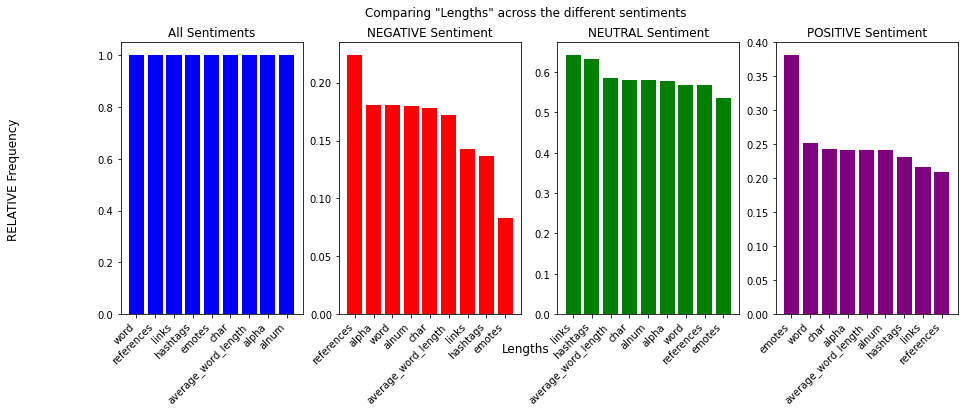

In [3]:
# test the fit_transform
lm = TweetMetrics()
train_lm_matrix = lm.fit_transform(train_tweets, train_sentiments)
print(train_lm_matrix.shape)

# generate training length dicts
train_lengths_dict = lm.generate_dict(train_tweets)

# visually compare the lengths over the sentiments
compare_bar_graphs(train_lengths_dict, train_sentiments, label="Lengths")


### Bag-of-Words Vectorizations

  (0, 774)	1
  (0, 253)	1
  (0, 96)	1
  (0, 1373)	1
  (0, 1070)	1
  (0, 499)	1
  (0, 1841)	1
  (0, 786)	1
(21802, 2000)
['abc' 'able' 'abortion' 'above' 'absolutely' 'accept' 'access'
 'according' 'account' 'across' 'act' 'action' 'actual' 'actually' 'add'
 'admin' 'af' 'afraid' 'after' 'afternoon']


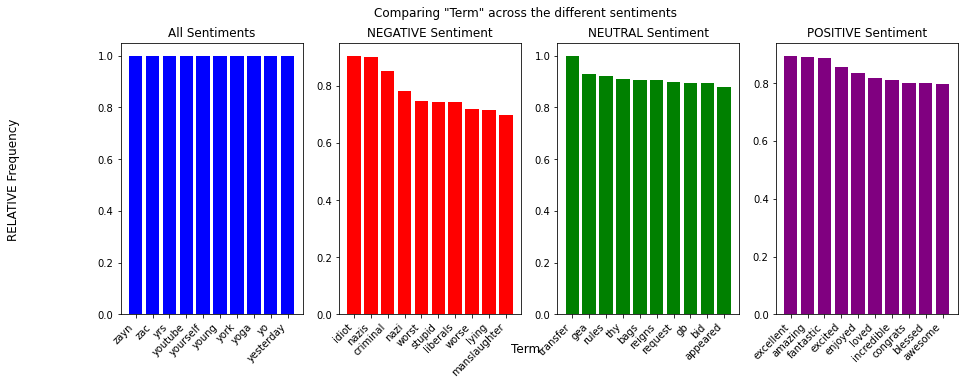

In [4]:
# test the fit_transform
bow = TweetBagOfWords(max_features=MAX_FEATURES)
train_bow_matrix = bow.fit_transform(train_tweets, train_sentiments)

# check that the transform was successful
print(train_bow_matrix.shape)

# create the bow dictionary
dict_bow = bow.generate_dict(train_tweets)

compare_bar_graphs(dict_bow, train_sentiments, label="Term", max_features=10)


### TF-IDF Vectorizations



  (0, 787)	0.37984370654249444
  (0, 1840)	0.22897307657269123
  (0, 502)	0.4248253515018077
  (0, 1071)	0.37186826407869206
  (0, 1375)	0.3967411929783116
  (0, 96)	0.22553372941127256
  (0, 255)	0.3979145630958619
  (0, 775)	0.34339840836203667
(21802, 2000)


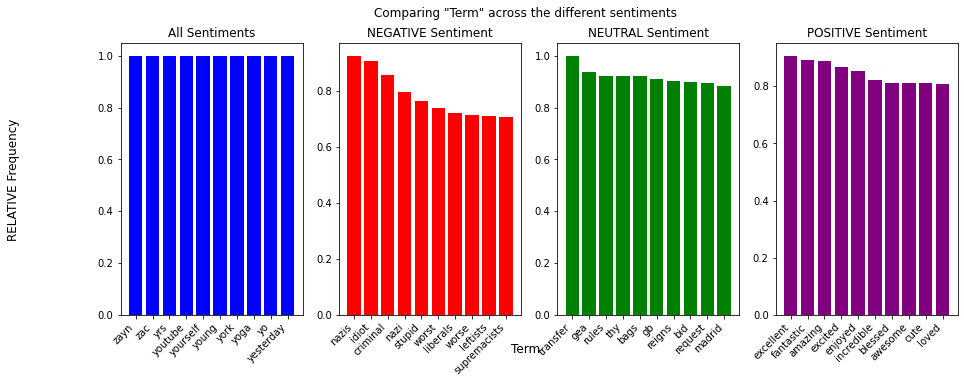

In [5]:
# test the fit_transform
tfidf = TweetTFIDF(max_features=MAX_FEATURES)
train_tfidf_matrix = tfidf.fit_transform(train_tweets, train_sentiments)

# check that the transform was successful
print(train_tfidf_matrix.shape)

# create the tfidf dictionary
dict_tfidf = tfidf.generate_dict(train_tweets)

compare_bar_graphs(dict_tfidf, train_sentiments, label="Term", max_features=10)


### Word Length Distribution

This could be average word length, or a list of the lengths of words in the tweet.

[[3. 1. 1. ... 0. 0. 0.]
 [3. 6. 1. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 ...
 [1. 2. 1. ... 0. 0. 0.]
 [2. 5. 0. ... 0. 0. 0.]
 [2. 4. 2. ... 0. 0. 0.]]
(21802, 37)
[7, 3, 8, 5, 2, 4, 9, 10, 6, 1, 11, 13, 14, 15, 16, 12, 17, 20, 19, 18, 24, 41, 26, 21, 25, 23, 33, 29, 35, 31, 28, 22, 40, 27, 39, 78, 55]


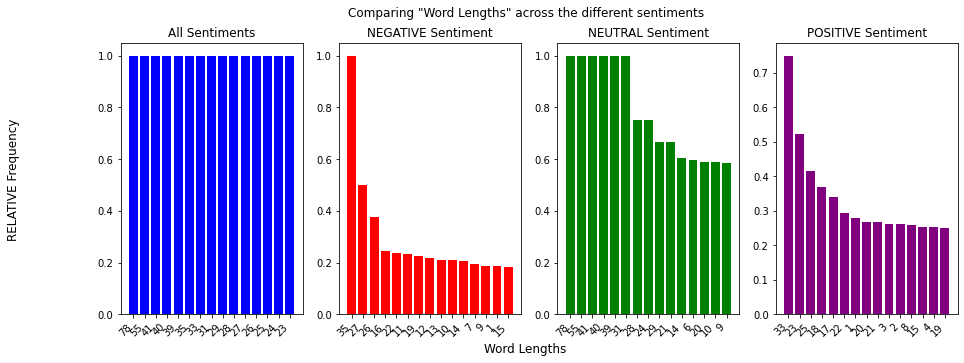

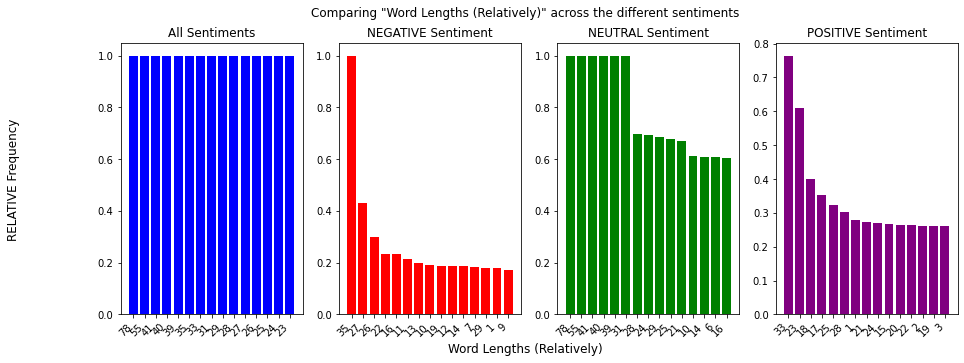

In [6]:
# test the fit_transform
wl = TweetWordLengths(max_features=MAX_FEATURES)
train_wl_matrix = wl.fit_transform(train_tweets, train_sentiments)
print(train_wl_matrix.shape)

# generate training and testing word length dicts
train_word_length_dict = wl.generate_dict(train_tweets)

# visually compare all the lengths over the sentiments
compare_bar_graphs(train_word_length_dict, train_sentiments,
                   label="Word Lengths", separate=False, max_features=15)

### Character Relative Frequencies

There may be information to gain from the occurrences of different characters in the tweet relative to its total length.

[[14.  3.  8. ...  0.  0.  0.]
 [27.  6. 12. ...  0.  0.  0.]
 [10.  3.  5. ...  0.  0.  0.]
 ...
 [ 5.  1.  4. ...  0.  0.  0.]
 [23. 10.  8. ...  0.  0.  0.]
 [23.  7. 11. ...  0.  0.  0.]]
(21802, 137)
[' ', 'd', 'o', 'c', 't', 'r', 's', 'h', 'i', 'a', 'm', 'p', 'g', 'n', 'l', 'e', 'u', ':', '/', '.', 'f', 'w', 'b', '9', 'v', '0', '#', 'y', '?', 'k', '(', '\t', 'j', "'", '5', '"', ',', '@', 'z', 'x', 'q', '4', '‚', 'ä', '¶', '1', '2', '-', '3', '7', '!', '8', '|', ')', '6', '[', ']', '&', ';', '$', 'ò', 'ô', '\uf8ff', 'ü', 'î', '≠', '_', '*', '=', 'á', 'ë', '∏', 'è', 'ω', 'í', 'õ', '+', 'â', 'ç', '†', 'ù', 'é', 'ì', '∑', 'ú', 'ö', '®', '%', 'ñ', 'å', '°', '§', '∫', '~', '√', 'º', '¬', '©', '¨', '•', '>', 'ï', '™', 'ß', '<', '„', 'ª', '\\', '£', 'π', '¢', 'ó', '`', 'ê', 'æ', '¥', '±', '^', '–', '∞', '—', '{', '}', '´', 'à', 'ã', 'ÿ', 'ø', '≥', 'û', 'µ', '·', '≤', '‰', '∂', 'ƒ', '\n']


C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 63743 (\uf8ff) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


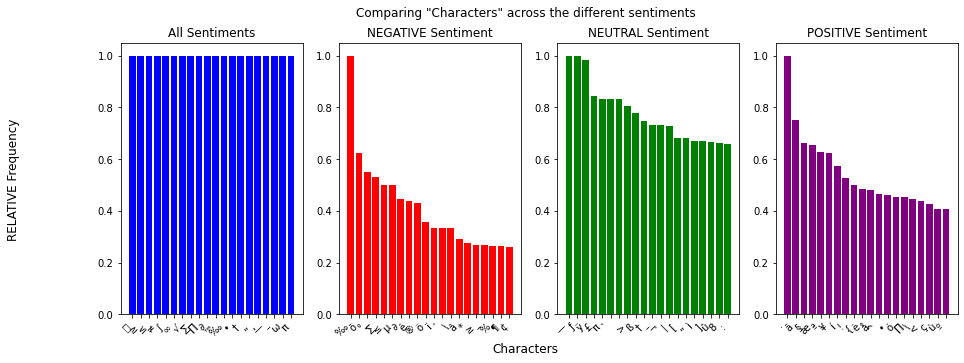

In [7]:
# test the fit_transform
cf = TweetCharacterFrequencies(alphabetic=False)
train_cf_matrix = cf.fit_transform(train_tweets, train_sentiments)
print(train_cf_matrix.shape)

# generate training frequency dict
train_char_freq_dict = cf.generate_dict(train_tweets)

# visually compare all the lengths over the sentiments
compare_bar_graphs(train_char_freq_dict, train_sentiments,
                   label="Characters", separate=False, max_features=20)


### Links

Some tweets have links to other websites or other tweets.
Links can be identified by the appearance of the `https://t.co/` redirect service.

This *numeric* feature will track the number of links in a single tweet. Linking could indicate some opinion is being stated on the linked text.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(21802, 2000)


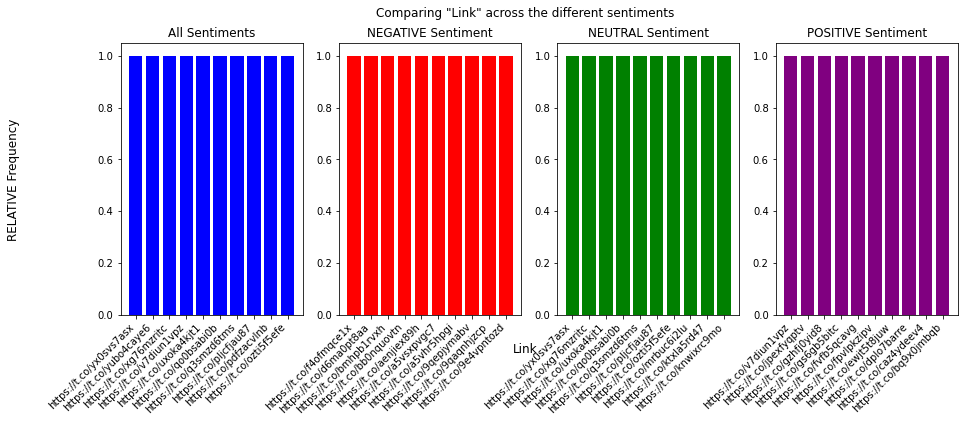

In [8]:
# test the fit_transform
li = TweetLinks(max_features=MAX_FEATURES)
train_li_matrix = li.fit_transform(train_tweets, train_sentiments)
print(train_li_matrix.shape)

# generate training and testing frequency dicts
train_link_counts = li.generate_dict(train_tweets)

# generate comparison plots
compare_bar_graphs(train_link_counts, train_sentiments,
                   label="Link", separate=False, max_features=10)


### Hashtags
Hashtags are used in twitter to link tweets with similar subjects together.
Extracting these from the tweets may help in grouping similar tweets together.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(21802, 2000)


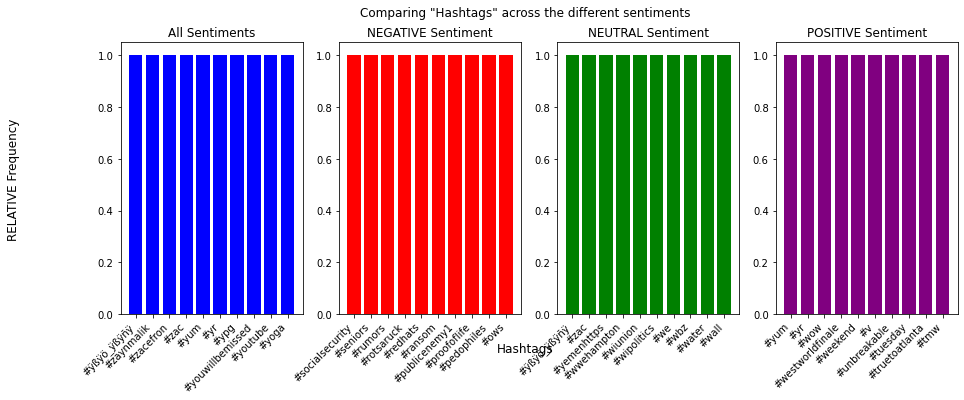

In [9]:
# test the fit_transform
ha = TweetHashtags(max_features=MAX_FEATURES)
train_ha_matrix = ha.fit_transform(train_tweets, train_sentiments)
print(train_ha_matrix.shape)

# generate training and testing frequency dicts
train_hashtag_counts = ha.generate_dict(train_tweets)

# generate comparison plots
compare_bar_graphs(train_hashtag_counts, train_sentiments,
                   label="Hashtags", separate=False, max_features=10)


### User References
`@` symbols are used in twitter to reference a specific user.
Extracting these from the tweets may help in grouping tweets with similar recipients.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(21802, 2000)


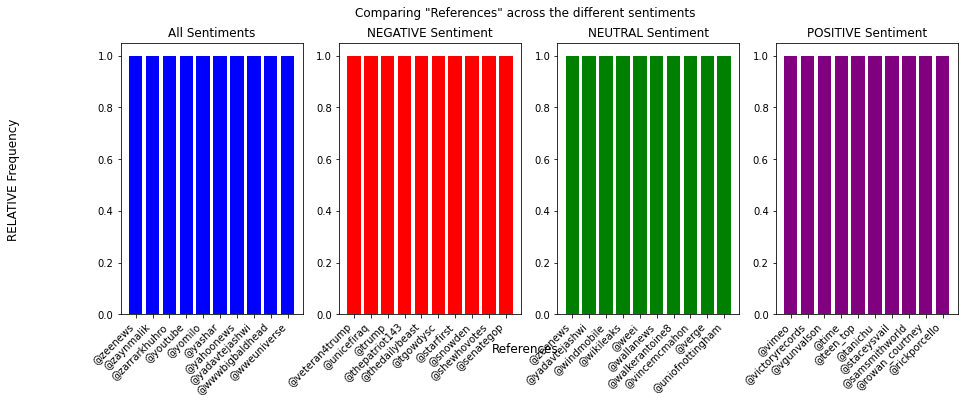

In [10]:
# test the fit_transform
ur = TweetReferences(max_features=MAX_FEATURES)
train_ur_matrix = ur.fit_transform(train_tweets, train_sentiments)
print(train_ur_matrix.shape)

# generate training and testing frequency dicts
train_ref_counts = ur.generate_dict(train_tweets)

# generate comparison plots
compare_bar_graphs(train_ref_counts, train_sentiments,
                   label="References", separate=False, max_features=10)


### Smiley Faces
`ASCII` emoji such as `:)`, `:(`, `:P` can indicate emotion, leading to potentially easier judgment on the sentiment of a tweet.

For the purposes of simplicity, emoji will be a combination of common eye symbols `;:B8=`, nose/middle symbols `',-"` and mouth symbols `LlPp|\/()[]VOo3`

[[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
(21802, 4)
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(21802, 34)


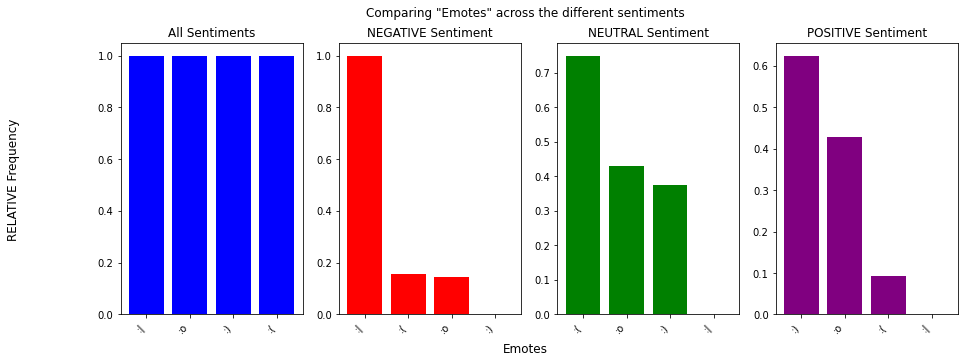

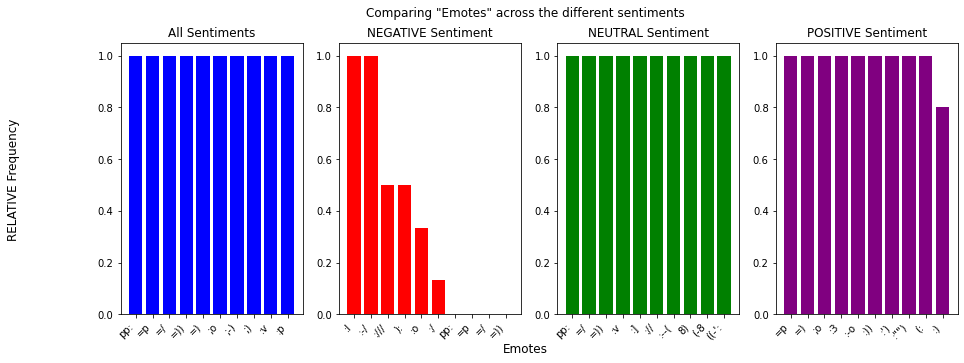

In [11]:
# test the fit_transform
em = TweetEmoticons()
train_em_matrix = em.fit_transform(train_tweets, train_sentiments)
print(train_em_matrix.shape)

# generate training emote frequency dicts
train_emote_counts = em.generate_dict(train_tweets)

# Try complex emoji (don't simplify to one of ':)' ':(' ':|' ':o' )
emc = TweetEmoticons(simplify=False)
train_emc_matrix = emc.fit_transform(train_tweets, train_sentiments)
print(train_emc_matrix.shape)

# generate training emote frequency dicts
train_emote_complex_counts = emc.generate_dict(train_tweets)

# generate comparison plots
compare_bar_graphs(train_emote_counts, train_sentiments,
                   label="Emotes", separate=False, max_features=10)

# generate comparison plots
compare_bar_graphs(train_emote_complex_counts, train_sentiments,
                   label="Emotes", separate=False, max_features=10)


### Quoting

If a Tweet is quoting an article or another person, it may indicate a certain sentiment.

In [12]:
# # define the list of binary is_quoting variables
# is_quoting = [re.search(r"\"", x) is not None for x in tweets]
# print(is_quoting[:10])
# int_is_quoting = [1 if iq else 0 for iq in is_quoting]
# int_is_quoting = np.array(int_is_quoting)

# compare_histograms(int_is_quoting, "Is it quoting?", False)


### Phonetics

Extracting the phones for a word (phonetic pronunciation breakdown).

[[2. 1. 5. ... 0. 0. 0.]
 [6. 1. 2. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 1. ... 0. 0. 0.]
 [8. 4. 1. ... 0. 0. 0.]
 [6. 1. 1. ... 1. 0. 0.]]
(21802, 72)


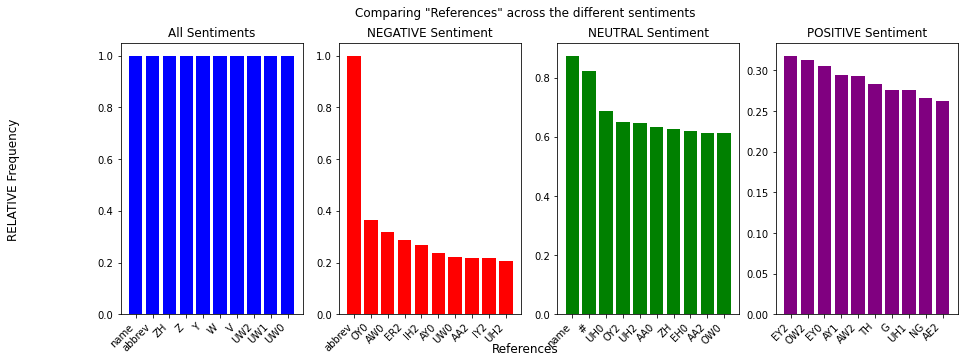

In [13]:
# test the fit_transform
ph = TweetPhonetics(max_features=MAX_FEATURES)
train_ph_matrix = ph.fit_transform(train_tweets, train_sentiments)
print(train_ph_matrix.shape)

# generate training and testing frequency dicts
train_pho_counts = ph.generate_dict(train_tweets)

# generate comparison plots
compare_bar_graphs(train_pho_counts, train_sentiments,
                   label="References", separate=False, max_features=10)


### Sibilance, Fricatives and Plosives. (Poetic Phonetics)

In the english language there are phonetic sounds which can have certain purpose when used in poetry. 
- **Plosives** describes `b`, `p`, `d`, `t`, `k`, `g` sounds which are used for an abrupt or sharp effect.
- **Hard Fricatives** describes hard `v`, `f`, `th` sounds which are used to convey a hard *vexed* effect.
- **Soft Fricatives** describes soft `f`, `th`, `ph` sounds which can be more relaxed and airy.
- **Sibilance** descibes `s`, `z`, `sh`, `ch`, `x` can be used *softly* or for *sinister* effect,

These effects are obviously heavily depended on the language of the tweets and may not actually mean anything in day-to-day use. This is just an interesting exploration of how they might correlate to the sentiments of the tweets.

[[6. 2. 1. 1. 0.]
 [4. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 ...
 [3. 1. 0. 0. 0.]
 [2. 1. 0. 0. 0.]
 [4. 4. 1. 0. 1.]]
(21802, 5)


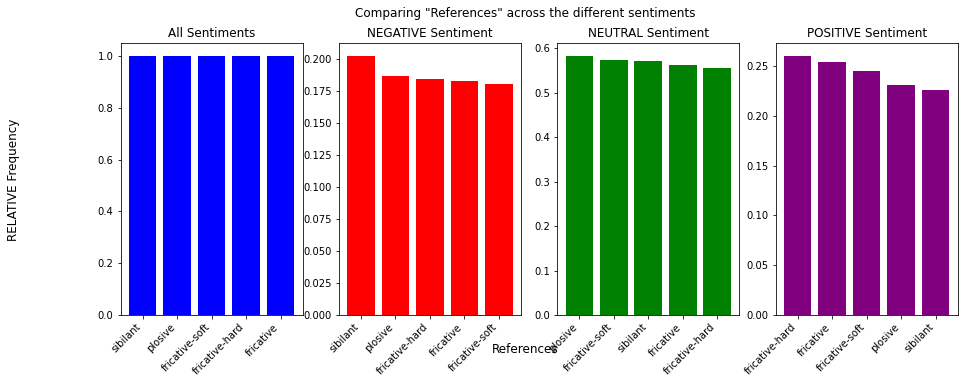

In [14]:
# test the fit_transform
po = TweetPoetics()
train_po_matrix = po.fit_transform(train_tweets, train_sentiments)
print(train_po_matrix.shape)

# generate training and testing frequency dicts
train_po_counts = po.generate_dict(train_tweets)

# generate comparison plots
compare_bar_graphs(train_po_counts, train_sentiments,
                   label="References", separate=False)
